# Imports and libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Helper functions

In [21]:
def getProjectRoot():
    REPO_NAME = "Group10_project"
    currentPath = os.getcwd()
    projectRoot = currentPath.split(REPO_NAME)[0] + REPO_NAME +"\\"

    return projectRoot

def getDataPaths(dataPath):
    for root, dirs, files in os.walk(dataPath):
        for file in files:
            # Get the full path to the file
            file_path = os.path.join(root, file)
            print(file_path)

def getEvaluationMetrics(y_test, y_pred, target):
    total_demand_mean = target.mean()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / total_demand_mean
    r2 = r2_score(y_test, y_pred)

    # Calculate Willmott's Index of Agreement (WI)
    def willmott_index(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((np.abs(y_pred - mean_observed) + np.abs(y_true - mean_observed)) ** 2)
        return 1 - (numerator / denominator)

    wi = willmott_index(y_test, y_pred)

    # Calculate Nash–Sutcliffe Efficiency (NSE) coefficient
    def nash_sutcliffe_efficiency(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((y_true - mean_observed) ** 2)
        return 1 - (numerator / denominator)

    nse = nash_sutcliffe_efficiency(y_test, y_pred)

    print(f'MAE: {mae:.2f}')
    print(f'Mean Squared Error (Regression): {mse:.2f}')
    print(f'R^2 Score (Regression): {r2:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'RRMSE: {rrmse:.2f}')
    print(f'Nash–Sutcliffe efficiency coefficient: {nse:.2f}')
    print(f'Willmott index: {wi:.2f}')


class LSSVMRegressor:
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        sq_dists = np.sum(X1**2, axis=1).reshape(-1,1) + \
                   np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-sq_dists / (2 * self.sigma**2))

    def fit(self, X, y):
        n_samples = X.shape[0]
        y = y.reshape(-1, 1)
        if self.kernel == 'linear':
            K = self._linear_kernel(X, X)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, X)

        Omega = K + np.eye(n_samples) / self.gamma

        # Construct matrices for the linear system
        ones = np.ones((n_samples, 1))
        A = np.block([[0, ones.T],
                      [ones, Omega]])
        B = np.vstack([0, y])

        # Solve the linear system
        solution = np.linalg.solve(A, B)
        self.b = solution[0]
        self.alpha = solution[1:].flatten()
        self.X_train = X

    def predict(self, X):
        if self.kernel == 'linear':
            K = self._linear_kernel(X, self.X_train)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, self.X_train)
        predictions = np.dot(K, self.alpha) + self.b
        return predictions.flatten()

# Wrapper for GridSearchCV
class LSSVMRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma
        self.model = LSSVMRegressor(gamma=self.gamma, kernel=self.kernel, sigma=self.sigma)

    def fit(self, X, y):
        self.model.gamma = self.gamma
        self.model.kernel = self.kernel
        self.model.sigma = self.sigma
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Data assets

In [7]:
projRoot = getProjectRoot()
print(getDataPaths(projRoot + "\\data\\"))
print(getDataPaths(projRoot + "\\extracted_data\\"))

f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\a.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\b.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\c.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\d.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partaa
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partab
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\temperature_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\totaldemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\SILO\40842 BRISBANE.csv
f:\UNSW Master of Data Science\ZZSC9020

# Data loading

In [14]:
dailyMergedNSW = pd.read_csv(projRoot + "data\\SILO\\daily_merged_nsw.csv")

# Data pre-processing

In [24]:
dailyMergedNSW = dailyMergedNSW.dropna()

data = dailyMergedNSW

# Create lag features for 'TOTALDEMAND' and 'TEMPERATURE'
lag_steps = [1, 2, 3, 7]  # Specify lag intervals (1 day, 2 days, 3 days, and 1 week)

for lag in lag_steps:
    data[f'TOTALDEMAND_lag_{lag}'] = data['TOTALDEMAND'].shift(lag)
    data[f'TEMPERATURE_lag_{lag}'] = data['TEMPERATURE'].shift(lag)

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# Convert the 'DATETIME' column to datetime format
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Exploratory data analysis 

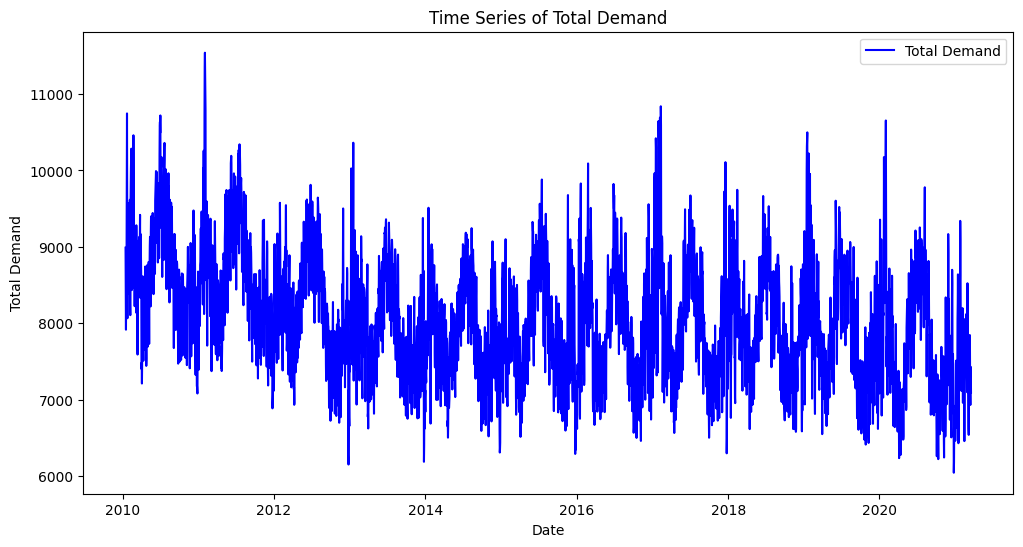

C:\Users\Geoffery\AppData\Local\Temp\ipykernel_16452\3390404762.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)


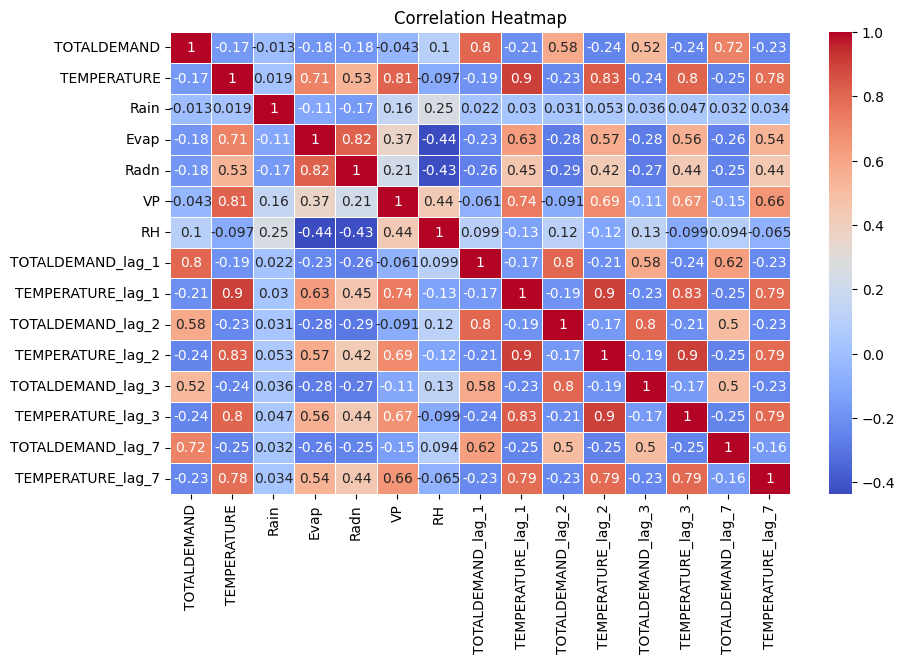

In [25]:
# Perform basic statistical summary of the dataset
summary_stats = data.describe()

# Plot the time series of TOTALDEMAND
plt.figure(figsize=(12, 6))
plt.plot(data['DATETIME'], data['TOTALDEMAND'], label='Total Demand', color='b')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.title('Time Series of Total Demand')
plt.legend()
plt.show()

# Display a correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

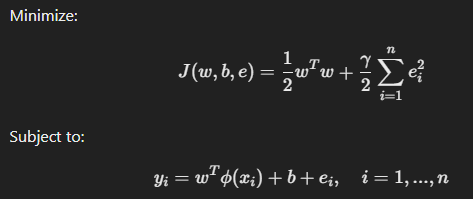

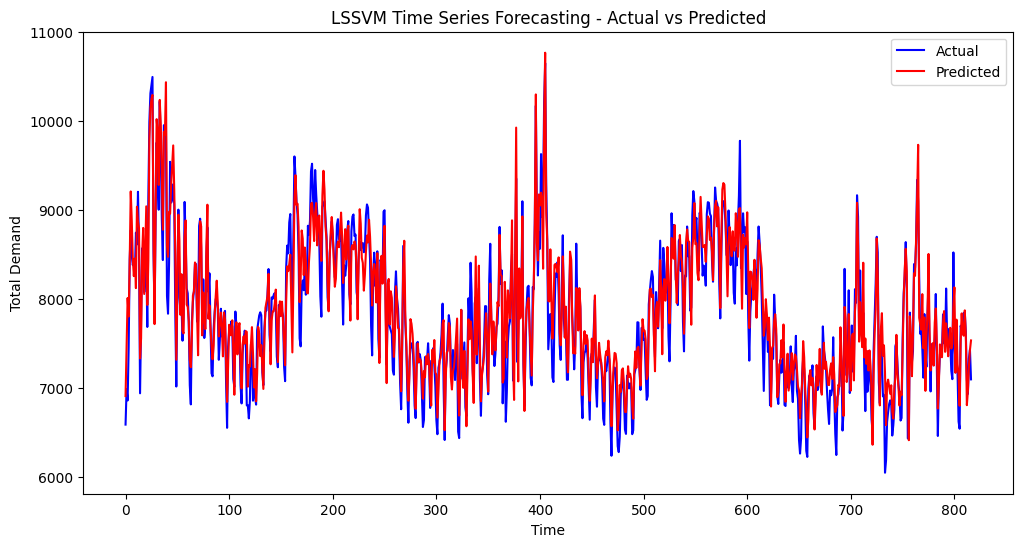

In [19]:
features = data.drop(columns=['DATETIME', 'TOTALDEMAND'])
target = data['TOTALDEMAND']

features = features.to_numpy()

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle=False)

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Initialize the LSSVM (using Support Vector Regression as a proxy)
lssvm_model = LSSVMRegressor(gamma=100, kernel='rbf', sigma=10)

# Fit the model on the training data
lssvm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lssvm_model.predict(X_test)

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual', color='b')
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', color='r')
plt.xlabel('Time')
plt.ylabel('Total Demand')
plt.title('LSSVM Time Series Forecasting - Actual vs Predicted')
plt.legend()
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(residuals)), residuals, label='Residuals', color='g')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals of LSSVM Time Series Forecasting')
plt.show()

In [20]:
getEvaluationMetrics(y_test, y_pred, target)

Mean Squared Error (Regression): 84782.09
R^2 Score (Regression): 0.86
RMSE: 291.17
RRMSE: 0.04
Willmott index: 0.40
Nash–Sutcliffe efficiency coefficient: -1517.66
MAE: 227.95


In [26]:
param_grid = {
    'gamma': [0.01, 0.1, 1, 10, 60, 100],
    'sigma': [0.01, 0.1, 1, 10, 60, 100]
}

grid_search = GridSearchCV(LSSVMRegressorWrapper(kernel='rbf'), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters (Regression):", grid_search.best_params_)

# Evaluate with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

getEvaluationMetrics(y_test, y_pred_best, target)